In [2]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
rho= 1  ## density
mu= 1  ## viscosity
u_in= 1
D= 1
L= 2

geom= dde.geometry.Rectangle(xmin= [-L/2, -D/2], xmax= [L/2, D/2])

def boundary_wall(X, on_boundary):
    print("X", X)
    print("on boundary", on_boundary)
    on_wall= np.logical_and(np.logical_or(np.isclose(X[1], -D/2, rtol= 1e-05, atol= 1e-08), np.isclose(X[1], D/2, rtol= 1e-05, atol= 1e-08)), on_boundary)
    return on_wall
    
def boundary_inlet(X, on_boundary):
    on_inlet= np.logical_and(np.isclose(X[0], -L/2, rtol= 1e-05, atol= 1e-08), on_boundary)
    return on_inlet

def boundary_outlet(X, on_boundary):
    on_outlet = np.logical_and(np.isclose(X[0], L/2, rtol=1e-05, atol=1e-08), on_boundary)
    return on_outlet

bc_wall_u= dde.DirichletBC(geom, lambda X: 0., boundary_wall, component= 0)
bc_wall_v= dde.DirichletBC(geom, lambda X: 0., boundary_wall, component= 1)

bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component= 0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_inlet, component= 1)

bc_outlet_p = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component=2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component=1)

In [6]:
def pde(X, Y):
    """Args:
    Y: network output [u, v, p],
    X: input coorsdinates [x, y]"""
    du_x = dde.grad.jacobian(Y, X, i= 0, j= 0)
    du_y = dde.grad.jacobian(Y, X, i=0, j= 1)
    dv_x= dde.grad.jacobian(Y, X, i= 1, j= 0)
    dv_y= dde.grad.jacobian(Y, X, i= 1, j= 1)
    dp_x= dde.grad.jacobian(Y, X, i=2, j= 0)
    dp_y= dde.grad.jacobian(Y, X, i=2, j= 1)
    
    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)

    pde_u = Y[:, 0:1] * du_x + Y[:, 1:2] * du_y + 1 / rho * dp_x - (mu / rho) * (du_xx + du_yy)
    pde_v = Y[:, 0:1] * dv_x + Y[:, 1:2] * dv_y + 1 / rho * dp_y - (mu / rho) * (dv_xx + dv_yy)
    
    pde_cont = du_x + dv_y
    
    return [pde_u, pde_v, pde_cont]


In [7]:
data= dde.data.PDE(
    geom,
    pde,
    [bc_wall_u,bc_wall_v,bc_inlet_u,bc_inlet_v,bc_outlet_p,bc_outlet_v],
    num_domain= 2000,
    num_boundary= 200,
    num_test= 200
)

X [1.  0.5]
on boundary True
X [ 0.5 -0.5]
on boundary True
X [-0.5  0.5]
on boundary True
X [-0.25 -0.5 ]
on boundary True
X [0.25 0.5 ]
on boundary True
X [ 1.   -0.25]
on boundary True
X [-1.    0.25]
on boundary True
X [-0.625 -0.5  ]
on boundary True
X [0.625 0.5  ]
on boundary True
X [ 0.875 -0.5  ]
on boundary True
X [-0.875  0.5  ]
on boundary True
X [ 0.125 -0.5  ]
on boundary True
X [-0.125  0.5  ]
on boundary True
X [1.    0.125]
on boundary True
X [-1.    -0.125]
on boundary True
X [-0.8125 -0.5   ]
on boundary True
X [0.8125 0.5   ]
on boundary True
X [ 0.6875 -0.5   ]
on boundary True
X [-0.6875  0.5   ]
on boundary True
X [-0.0625 -0.5   ]
on boundary True
X [0.0625 0.5   ]
on boundary True
X [ 1.     -0.0625]
on boundary True
X [-1.      0.0625]
on boundary True
X [-0.4375 -0.5   ]
on boundary True
X [0.4375 0.5   ]
on boundary True
X [ 1.     -0.4375]
on boundary True
X [-1.      0.4375]
on boundary True
X [ 0.3125 -0.5   ]
on boundary True
X [-0.3125  0.5   ]
on bound

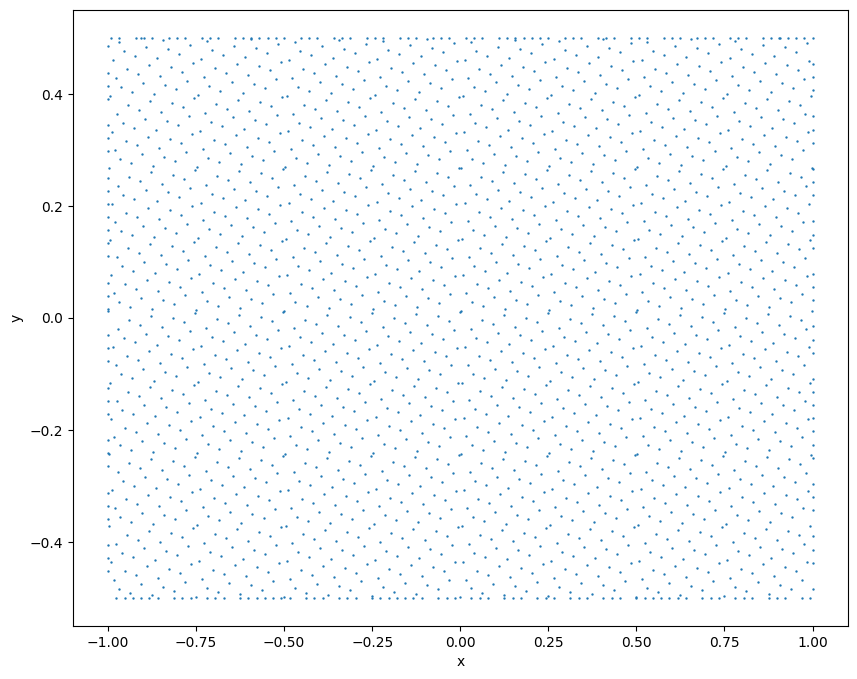

In [11]:
plt.figure(figsize=(10, 8))
plt.scatter(data.train_x_all[:, 0], data.train_x_all[:, 1], s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [12]:
## defining neural network
net = dde.maps.FNN([2] + [64]*5 + [3], 'tanh', 'Glorot uniform')
model = dde.Model(data, net)

model.compile('adam', lr= 1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.070086 s

'compile' took 1.377571 s



In [13]:
losshistory, train_state = model.train(epochs=10000)


Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [6.54e-02, 4.94e-02, 6.93e-02, 1.61e-02, 7.70e-02, 1.37e+00, 8.81e-02, 5.09e-02, 9.17e-02]    [6.67e-02, 4.72e-02, 7.22e-02, 1.61e-02, 7.70e-02, 1.37e+00, 8.81e-02, 5.09e-02, 9.17e-02]    []  
1000      [9.73e-04, 8.04e-04, 8.22e-03, 2.65e-02, 1.72e-02, 3.53e-02, 1.01e-03, 4.27e-04, 2.38e-05]    [5.01e-04, 4.96e-04, 4.94e-03, 2.65e-02, 1.72e-02, 3.53e-02, 1.01e-03, 4.27e-04, 2.38e-05]    []  
2000      [3.80e-03, 2.24e-03, 5.37e-03, 2.13e-02, 1.27e-02, 2.67e-02, 1.03e-03, 2.03e-04, 1.63e-04]    [2.89e-03, 1.82e-03, 3.26e-03, 2.13e-02, 1.27e-02, 2.67e-02, 1.03e-03, 2.03e-04, 1.63e-04]    []  
3000      [1.00e-03, 9.53e-04, 3.60e-03, 1.83e-02, 1.02e-02, 2.18e-02, 2.30e-03, 1.48e-04, 1.04e-05]    [5.45e-04, 6.32e-04, 1.69e-03, 1.83e-02, 1.02e-02, 2.18e-0

In [14]:
dde.saveplot(losshistory, train_state, issave=False, isplot=False)


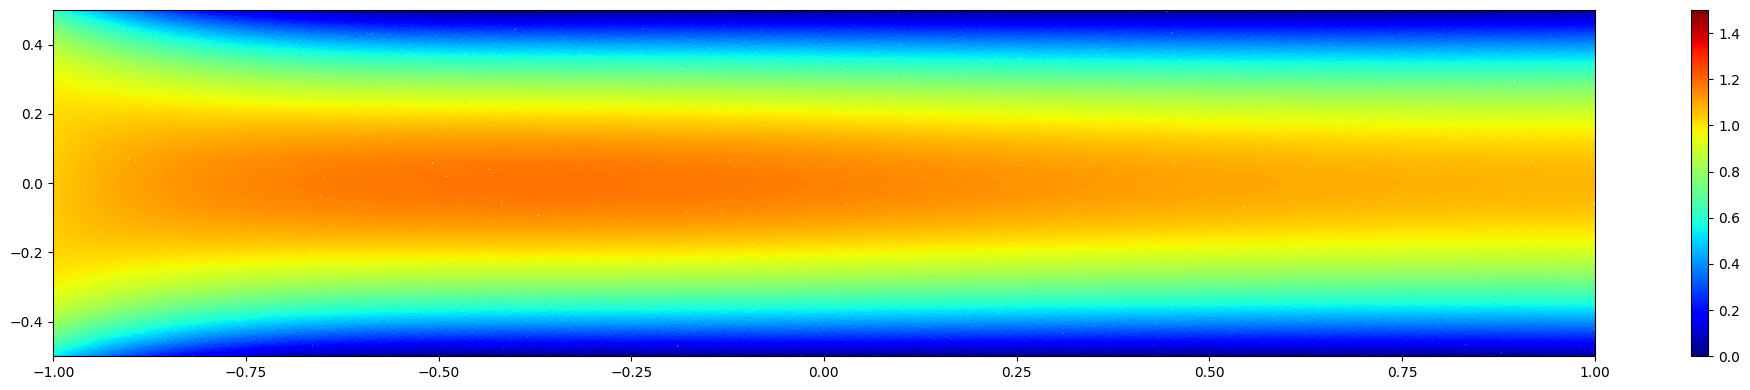

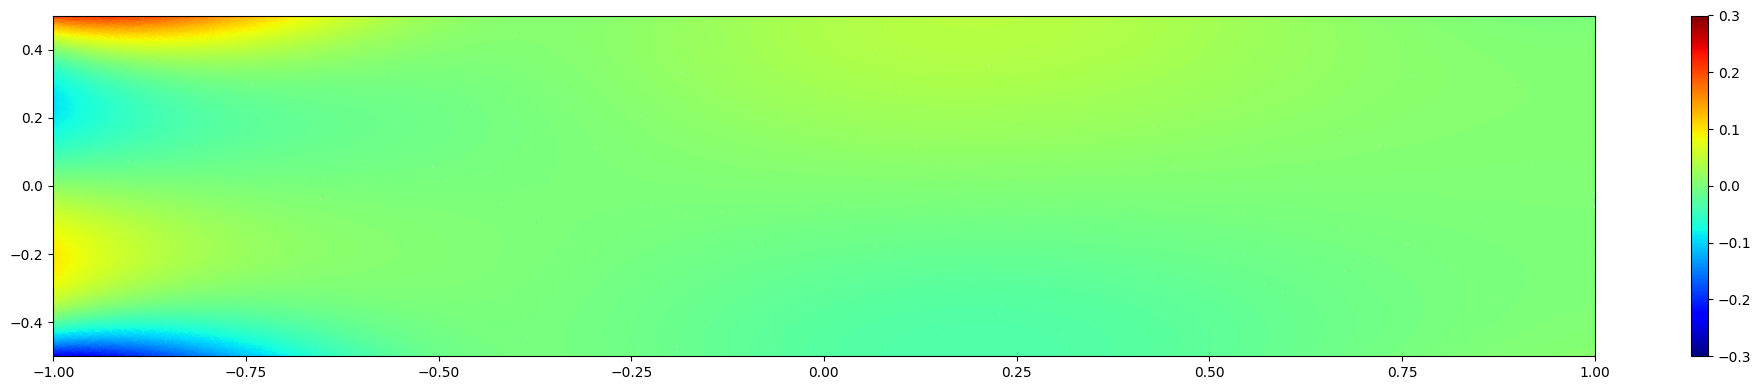

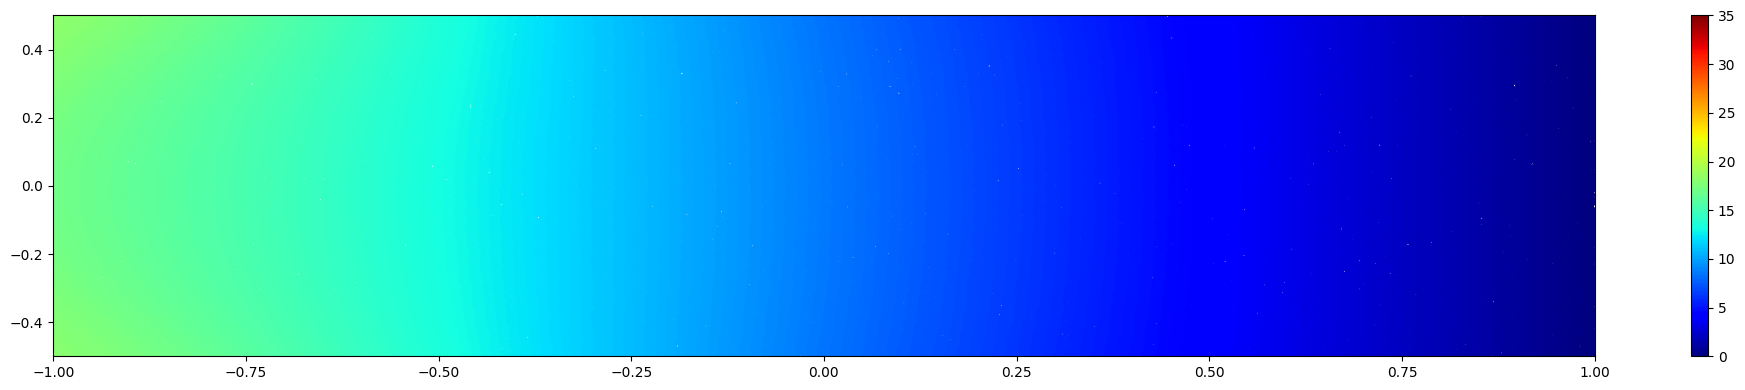

In [15]:
samples= geom.random_points(500000)
result= model.predict(samples)

color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize=(20,4))
    plt.scatter(samples[:,0],
               samples[:,1],
               c=result[:,idx],
               cmap='jet',
               s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0 - L/2, L - L/2))
    plt.ylim((0 - D/2, D - D/2))
    plt.tight_layout()
    plt.show()
